# Image Captioning using LSTM
This use-case provides a demo of how LSTM can be used for generating descriptions of images using seq2seq.
In our use-case, we will use flickr8k dataset. 

The dataset contains over 8,000 images each with 5 different caption annotations.  We will be using 6000 images for training and 1000 images for validation  


*Workflow:*

1. Understanding the problem
2. Collecting the data
3. Data preprocessing
4. Extract features using pre-trained vgg16 model(CNN) 
5. Build Model using LSTM
6. Training the dataset
7. Translate

## 1. Understanding the problem 
The problem statement is to generate description from images. For this purpose, we will be using CNN-LSTM model. 

##Import the libraries 

In [1]:
import tensorflow as tf
import re
from pickle import dump,load
from os import listdir
from numpy import array,argmax
from IPython.display import Image, display

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array 
from keras.preprocessing.text import Tokenizer
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add

from nltk.translate.bleu_score import corpus_bleu

###Load the captions

In [2]:
import os
captions_folder_all = '/captions/'
if not os.path.exists(os.path.abspath('.') + captions_folder_all):
  #download zip file and extract the data
  annotation_zip_file = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip',
                                          extract = True)
  all_captions = os.path.dirname(annotation_zip_file)+'/Flickr8k.token.txt'
  train_captions = os.path.dirname(annotation_zip_file)+'/Flickr_8k.trainImages.txt'
  test_captions = os.path.dirname(annotation_zip_file)+'/Flickr_8k.devImages.txt'
  os.remove(annotation_zip_file)

2342912/2340801 [==============================] - 0s 0us/step


###Load the images


In [3]:
captions_folder_all = '/images/'
if not os.path.exists(os.path.abspath('.') + captions_folder_all):
  #download zip file and extract the data
  images_zip_file = tf.keras.utils.get_file('images.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip',
                                          extract = True)
  all_images = os.path.dirname(images_zip_file)+'/Flicker8k_Dataset'
  os.remove(images_zip_file)

1115422720/1115419746 [==============================] - 13s 0us/step


##Pre-process text data



In [4]:
# read the caption file
file1 = open(all_captions,'r')
data = file1.read()
file1.close()

In [5]:
descr = dict()
for line in data.split('\n'):
  token = line.split()
  # skip blank lines
  if len(token)<2:
    continue
  image_id,image_descr = token[0],token[1:]
  image_id = image_id.split('.')[0]
  # add special <start> and <end> token to every caption 
  image_descr = '<start> '+' '.join(image_descr)+' <end>'
  
  if image_id not in descr:
    descr[image_id]=list()
  descr[image_id].append(image_descr)

In [6]:
descr['101654506_8eb26cfb60']

['<start> A brown and white dog is running through the snow . <end>',
 '<start> A dog is running in the snow <end>',
 '<start> A dog running through snow . <end>',
 '<start> a white and brown dog is running through a snow covered field . <end>',
 '<start> The white and brown dog is running over the surface of the snow . <end>']

In [7]:
for key,des in descr.items():
  for i in range(len(des)):
    # convert into lowercase
    d = des[i].lower()
    # keep only those words which have only alphabets, remove punctuations, digits,etc
    d = re.sub(r'\w*[^a-z\s<>]+\w*','',d)
    des[i]=d
  descr[key]=des

In [8]:
vocab = set()
for k,v in descr.items():
    [vocab.update(l.split()) for l in v]
print('Original Vocabulary Size: %d' % len(vocab))

Original Vocabulary Size: 8371


In [9]:
descr['101654506_8eb26cfb60']

['<start> a brown and white dog is running through the snow  <end>',
 '<start> a dog is running in the snow <end>',
 '<start> a dog running through snow  <end>',
 '<start> a white and brown dog is running through a snow covered field  <end>',
 '<start> the white and brown dog is running over the surface of the snow  <end>']

In [10]:
def load_text(descr,filename):
  #loads the text data corresponding to train and test images
  length=0
  des = dict()
  file = open(filename,'r')
  keys = file.read() 
  for k in keys.split('\n'):
    if len(k)<2:
      continue
    image_id = k.split('.')[0]
    des[image_id] = descr.get(image_id)
    length+=1
  file.close()
  print('Number of image ids:', length)
  return des

In [11]:
train_descr = load_text(descr,train_captions)
test_descr = load_text(descr,test_captions)


Number of image ids: 6000
Number of image ids: 1000


##Pre-process Image Data

1. To extract features from the images, we are using the pre-trained VGG-16 model
2. We will remove the output layer of vgg16 and use the output from the last second layer as feature 
3. The shape of the features will be 1 x 4096 
4. Store the features in a pickle file   

In [12]:
model = VGG16()
# pop the last layer to take the output from last second layer
model.layers.pop()
model = Model(inputs = model.inputs , outputs = model.layers[-1].output)

features = dict()
for name in listdir(all_images):
  filename = all_images+'/' + name
  # prepare the image for the VGG model
  image = load_img(filename,target_size=(224,224))
  image = img_to_array(image)
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
  image = preprocess_input(image)
  # generate image features
  feature = model.predict(image, verbose=0)
  image_id = name.split('.')[0]
  # map the image id with the features
  features[image_id] = feature
print('Extracted Features:', len(features))
# Save the features on hard disk
dump(features, open('features.pkl', 'wb'))

553467904/553467096 [==============================] - 11s 0us/step
Extracted Features: 8091


In [ ]:
#load the image features from the pickle file
def load_images_features(fn_features,fn_data):
  length=0
  feat = dict()
  file1 = open(fn_data,'r')
  file2 = open(fn_features,'rb')
  f = load(file2)
  keys = file1.read() 
  for k in keys.split('\n'):
    if len(k)<2:
      continue
    image_id = k.split('.')[0]
    feat[image_id] = f[image_id]
    length+=1
  file1.close()
  file2.close()
  print('Number of instances:', length)
  return feat

In [ ]:
train_features = load_images_features('/content/features.pkl',train_captions)
test_features = load_images_features('/content/features.pkl',test_captions)

Number of instances: 6000
Number of instances: 1000


###Tokenize the words

In [ ]:
def tokenizer(descr):
  # create Tokenizer object
  d=[]
  for key in descr.keys():
    for i in descr[key]:
      d.append(i)
  tokenize = Tokenizer()
  tokenize.fit_on_texts(d)
  return tokenize

In [ ]:
tokenize = tokenizer(train_descr)
vocab_size = len(tokenize.word_index) + 1

In [ ]:
print(vocab_size)

7275


In [ ]:
d=[]
for key in train_descr.keys():
  for i in train_descr[key]:
    d.append(i)
maxlen = max(len(i.split()) for i in d)
print('maximum length of caption in training data:', maxlen)

maximum length of caption in training data: 36


In [ ]:
# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, desc_list, photo, vocab_size):
	x1, x2, y = list(), list(), list()
	for desc in desc_list:
		seq = tokenizer.texts_to_sequences([desc])[0]
		for i in range(1, len(seq)):
			in_seq, out_seq = seq[:i], seq[i]
			# pad input sequence
			in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
			# encode output sequence
			out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
			x1.append(photo)
			x2.append(in_seq)
			y.append(out_seq)
	return array(x1), array(x2), array(y)
 

###Generator to generate the data for training. By using generator function we can train the model with lower ram space

In [ ]:
def data_generator(descriptions, images, tokenizer, max_length, vocab_size):
	# generator function to generate data for training
	while 1:
		for key, desc_list in descriptions.items():
			image = images[key][0]
			in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, image, vocab_size)
			yield [in_img, in_seq], out_word

###Create the model

In [ ]:
def define_model(vocab_size, max_length):
	# feature extractor model
	inputs1 = Input(shape=(1000,))
	fe1 = Dropout(0.5)(inputs1)
	fe2 = Dense(256, activation='relu')(fe1)
	# sequence model
	inputs2 = Input(shape=(max_length,))
	se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
	se2 = Dropout(0.5)(se1)
	se3 = LSTM(256)(se2)
	# decoder model
	decoder1 = add([fe2, se3])
	decoder2 = Dense(256, activation='relu')(decoder1)
	outputs = Dense(vocab_size, activation='softmax')(decoder2)
	# tie it together [image, seq] [word]
	model = Model(inputs=[inputs1, inputs2], outputs=outputs)
	
	model.compile(loss='categorical_crossentropy', optimizer='adam')
	model.summary()
	return model

###Train the model

In [ ]:
model = define_model(vocab_size, maxlen)
# train the model, run epochs manually and save after each epoch
epochs = 10
steps = len(train_descr)
for i in range(epochs):
	# generate the data
	generator = data_generator(train_descr, train_features, tokenize, maxlen, vocab_size)
  # fit the data
	model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
  # save the model
	model.save('model_' + str(i) + '.h5')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 36)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 36, 256)      1862400     input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 1000)         0           input_2[0][0]                    
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


6000/6000 [==============================] - 693s 116ms/step - loss: 2.5655


###Generate description using our model

In [ ]:
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None
 
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# feed the input with <start>
	in_text = '<start>'
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad the input sequence
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert softmax probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'end':
			break
	return in_text

###Evaluate the model

We will evaluate our model on test data. For evaluation, BLEU score from nltk library will be used. BLEU is a score used to compare generated text data to one or more reference text data  

In [ ]:
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
	actual, predicted = list(), list()
	# step over the whole set
	for key, desc_list in descriptions.items():
		yhat = generate_desc(model, tokenize, photos[key], max_length)
			# store actual and predicted
		references = [d.split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))

In [ ]:
evaluate_model(model, test_descr, test_features, tokenize, maxlen)

BLEU-1: 0.492969


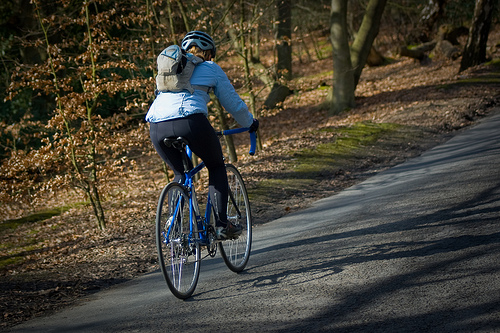

In [ ]:
display(Image('/content/Flicker8k_Dataset/3346918203_986dca6641.jpg'))

In [ ]:
yhat = generate_desc(model, tokenize, test_features['3346918203_986dca6641'], maxlen)

In [ ]:
yhat

'<start> a man in a helmet is riding a bicycle on a dirt track end'